# Intro

This notebook is to demonstrate how to convert a [libpgm](https://github.com/CyberPoint/libpgm) discrete Bayesian Belief Network (BBN) into a py-bbn BBN one. The JSON data specified [here](https://pythonhosted.org/libpgm/unittestdict.html) is the example taken.

In [1]:
json_data = {
    "V": ["Letter", "Grade", "Intelligence", "SAT", "Difficulty"],
    "E": [["Difficulty", "Grade"],
        ["Intelligence", "Grade"],
        ["Intelligence", "SAT"],
        ["Grade", "Letter"]],
    "Vdata": {
        "Letter": {
            "ord": 4,
            "numoutcomes": 2,
            "vals": ["weak", "strong"],
            "parents": ["Grade"],
            "children": None,
            "cprob": {
                "['A']": [.1, .9],
                "['B']": [.4, .6],
                "['C']": [.99, .01]
            }
        },

        "SAT": {
            "ord": 3,
            "numoutcomes": 2,
            "vals": ["lowscore", "highscore"],
            "parents": ["Intelligence"],
            "children": None,
            "cprob": {
                "['low']": [.95, .05],
                "['high']": [.2, .8]
            }
        },

        "Grade": {
            "ord": 2,
            "numoutcomes": 3,
            "vals": ["A", "B", "C"],
            "parents": ["Difficulty", "Intelligence"],
            "children": ["Letter"],
            "cprob": {
                "['easy', 'low']": [.3, .4, .3],
                "['easy', 'high']": [.9, .08, .02],
                "['hard', 'low']": [.05, .25, .7],
                "['hard', 'high']": [.5, .3, .2]
            }
        },

        "Intelligence": {
            "ord": 1,
            "numoutcomes": 2,
            "vals": ["low", "high"],
            "parents": None,
            "children": ["SAT", "Grade"],
            "cprob": [.7, .3]
        },

        "Difficulty": {
            "ord": 0,
            "numoutcomes": 2,
            "vals": ["easy", "hard"],
            "parents": None,
            "children": ["Grade"],
            "cprob":  [.6, .4]
        }
    }
}

# Conversion

~~Here we kludge how to build a libpgm discrete network. Note that libpgm requires node data and a skeleton. Since I could not find a factory method to read in from a dictionary or JSON string (they only show how to read the JSON data from a file), I took a look at the code and manually constructed a discrete BBN in libpgm. If the libpgm API changes, then this all might break too.~~

Note that we do **NOT** support dependency on `libpgm` anymore since it is not Python 3.x compatible. You will have to get either the JSON string value or the dictionary representation to work with py-bbn. The culprit with libgpm is [this line here](https://github.com/CyberPoint/libpgm/blob/master/libpgm/discretebayesiannetwork.py#L87). After you have the JSON or dictionary specifying a libpgm BBN, you can use the `Factory` to create a py-bbn BBN and perform exact inference as follows.

In [2]:
from pybbn.graph.dag import Bbn
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.pptc.inferencecontroller import InferenceController
from pybbn.graph.factory import Factory

bbn = Factory.from_libpgm_discrete_dictionary(json_data)

You may also visualize the directed acylic graph (DAG) of the BBN through [networkx](https://networkx.github.io/).

/home/super/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/super/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


Text(0.5, 1.0, 'libpgm BBN DAG')

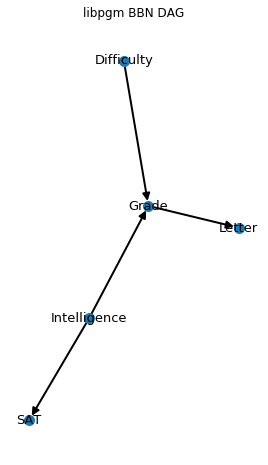

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import networkx as nx

nx_graph, labels = bbn.to_nx_graph()
pos = nx.nx_agraph.graphviz_layout(nx_graph, prog='neato')

plt.figure(figsize=(10, 8))
plt.subplot(121) 
nx.draw(
    nx_graph, 
    pos=pos, 
    with_labels=True, 
    labels=labels,
    arrowsize=15,
    edge_color='k',
    width=2.0,
    style='dash',
    font_size=13,
    font_weight='normal',
    node_size=100)
plt.title('libpgm BBN DAG')

# Inference

Now, create a join tree.

In [4]:
join_tree = InferenceController.apply(bbn)

Here, we visualize the marginal probabilities without observations and with different observations.

In [5]:
import pandas as pd

def potential_to_df(p):
    data = []
    for pe in p.entries:
        try:
            v = pe.entries.values()[0]
        except:
            v = list(pe.entries.values())[0]
        p = pe.value
        t = (v, p)
        data.append(t)
    return pd.DataFrame(data, columns=['val', 'p'])

def potentials_to_dfs(join_tree):
    data = []
    for node in join_tree.get_bbn_nodes():
        name = node.variable.name
        df = potential_to_df(join_tree.get_bbn_potential(node))
        t = (name, df)
        data.append(t)
    return data

marginal_dfs = potentials_to_dfs(join_tree)

# insert an observation evidence for when SAT=highscore
ev = EvidenceBuilder() \
    .with_node(join_tree.get_bbn_node_by_name('SAT')) \
    .with_evidence('highscore', 1.0) \
    .build()
join_tree.unobserve_all()
join_tree.set_observation(ev)

sat_high_dfs = potentials_to_dfs(join_tree)

# insert an observation evidence for when SAT=lowscore
ev = EvidenceBuilder() \
    .with_node(join_tree.get_bbn_node_by_name('SAT')) \
    .with_evidence('lowscore', 1.0) \
    .build()
join_tree.unobserve_all()
join_tree.set_observation(ev)

sat_low_dfs = potentials_to_dfs(join_tree)

# merge all dataframes so we can visualize then side-by-side
all_dfs = []
for i in range(len(marginal_dfs)):
    all_dfs.append(marginal_dfs[i])
    all_dfs.append(sat_high_dfs[i])
    all_dfs.append(sat_low_dfs[i])

Plot the marginal probabilities.

* The first column are the marginal probabilities without any observations.
* The second column are the marginal probabiliities with SAT=highscore.
* The third column are the marginal probabilites with SAT=lowscore.

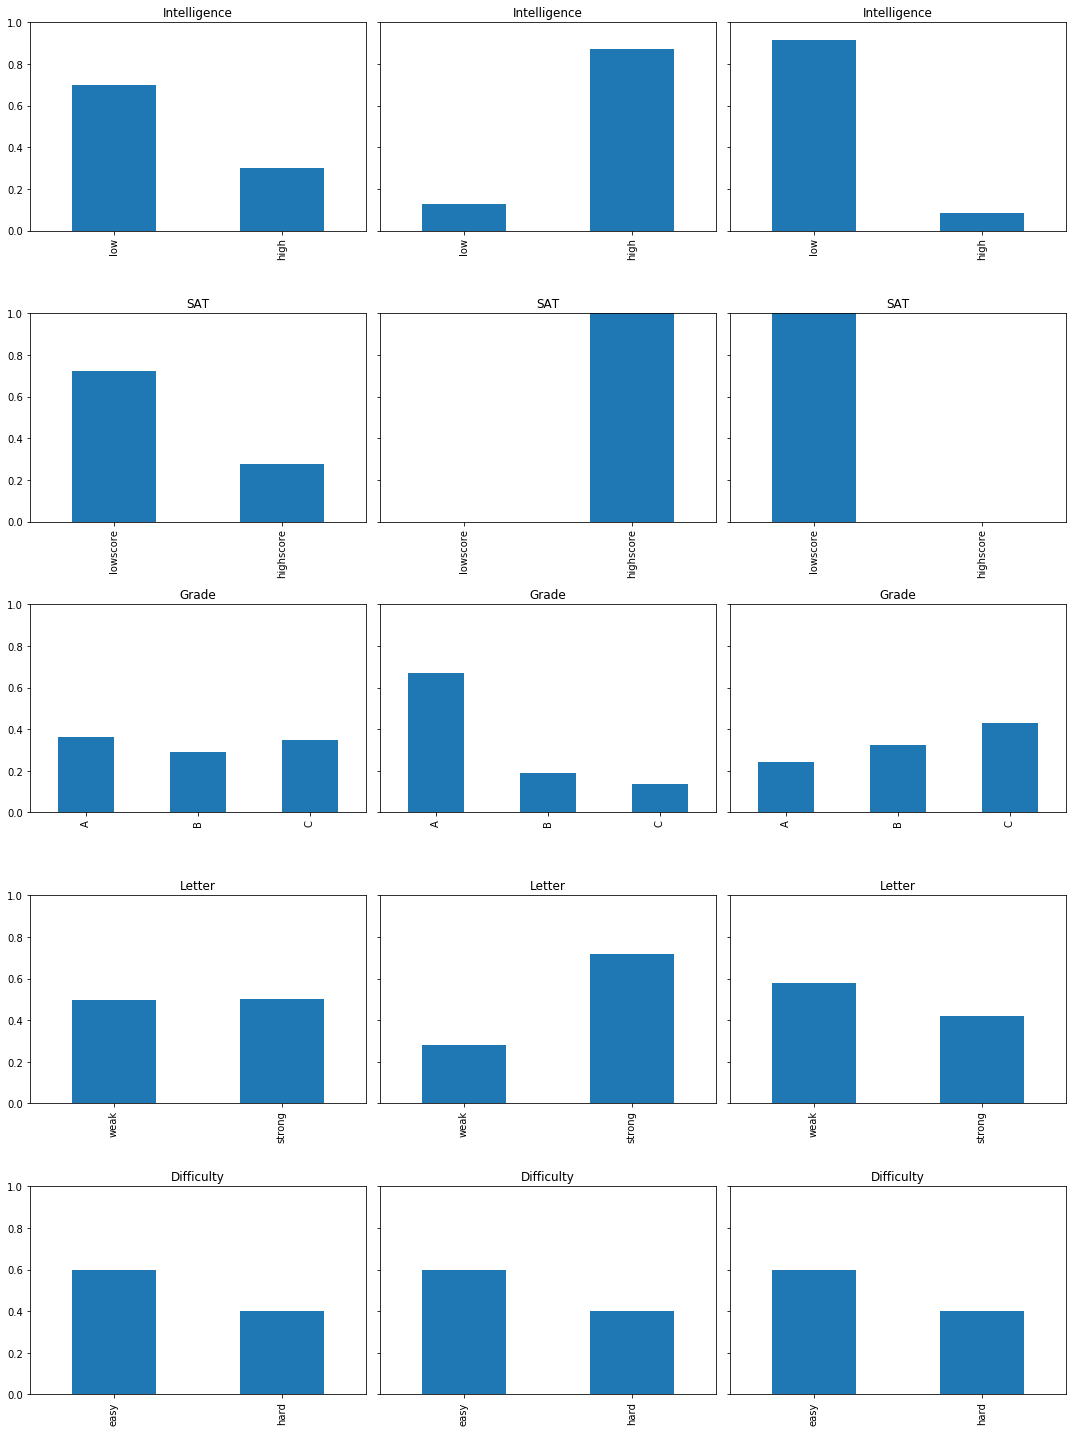

In [6]:
import numpy as np

fig, axes = plt.subplots(len(marginal_dfs), 3, figsize=(15, 20), sharey=True)
for i, ax in enumerate(np.ravel(axes)):
    all_dfs[i][1].plot.bar(x='val', y='p', legend=False, ax=ax)
    ax.set_title(all_dfs[i][0])
    ax.set_ylim([0.0, 1.0])
    ax.set_xlabel('')
plt.tight_layout()